In [12]:
import h5py
from lightguide import filters
import numpy as np
import matplotlib.pyplot as plt


data = h5py.File('/home/marius/Downloads/trace_POPO.PC1PC6..SHZSHZ.h5')

data.keys()
corrs = data['corr_data']
first_tr = corrs[tuple(corrs.keys())[0]]

ntraces = len(corrs)
nsamples = first_tr.size


corr_data = np.zeros((ntraces, nsamples))

for itr, data in enumerate(corrs.values()):
    corr_data[itr] = data

corr_data = corr_data.astype(np.float32)

In [156]:
window_size = 16
filtered_norm = filters.afk_filter(corr_data, window_size=window_size, overlap=int(window_size / 2 - 1), exponent=0.8, normalize_power=True)
filtered = filters.afk_filter(corr_data, window_size=window_size, overlap=int(window_size / 2 - 1), exponent=0.8, normalize_power=False)

# width = 64
# filtered_rect = filters.afk_filter_rectangular(corr_data, window_size=(32, width), overlap=(15, int(width/2 - 1)), exponent=0.8, normalize_power=False)

Text(0.5, 0, 'Sample')

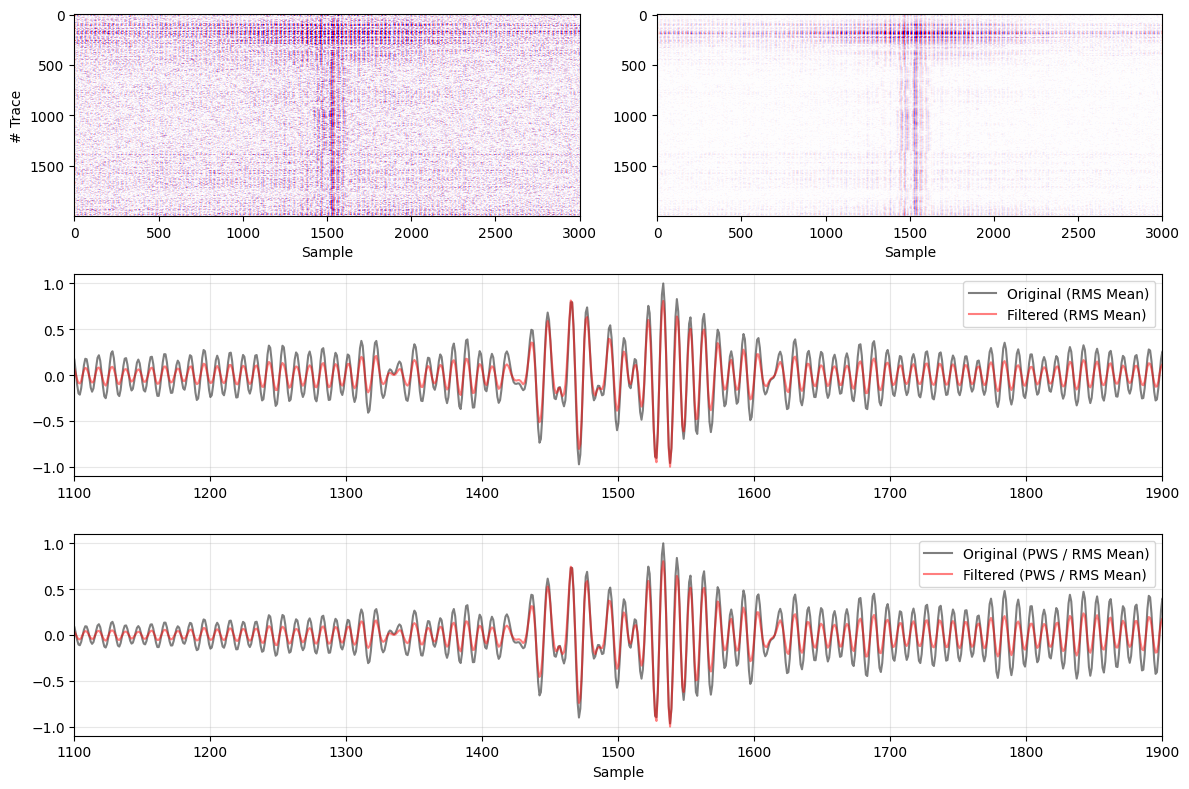

In [158]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal

fig = plt.figure(tight_layout=True, figsize=(12, 8))
gs = gridspec.GridSpec(3, 2)

filt_data = filtered

def plot_correlograms(ax, data) -> None:
    vmax = np.abs(data).max()
    ax.imshow(data, vmin=-vmax, vmax=vmax, cmap='seismic', interpolation='none', aspect='auto')
    ax.set_xlabel('Sample')


ax = fig.add_subplot(gs[0, 0])
plot_correlograms(ax, corr_data)
ax.set_ylabel('# Trace')

ax = fig.add_subplot(gs[0, 1])
plot_correlograms(ax, filt_data)


def stack(data, rms_norm: bool=True, pws: bool=False):
    own_data = data.copy()
    if rms_norm:
        own_data /= np.sqrt(np.mean(own_data**2, axis=1))[:, np.newaxis]

    own_data = own_data.sum(axis=0)
    if pws:
        hilbert = signal.hilbert(data, axis=1)
        instant_phase = np.unwrap(np.angle(hilbert), axis=1)
        phase_stack = stack(instant_phase, rms_norm=rms_norm, pws=False)
        own_data *= np.abs(phase_stack ** 2)

    return own_data / np.abs(own_data).max()

ax = fig.add_subplot(gs[1, :])
ax.plot(stack(corr_data, pws=False), alpha=0.5, c='k', label='Original (RMS Mean)')
ax.plot(stack(filt_data, pws=False), alpha=0.5, c='r', label='Filtered (RMS Mean)')
ax.grid(alpha=.3)
ax.set_xlim(1100, 1900)
ax.legend()

ax = fig.add_subplot(gs[2, :])
ax.plot(stack(corr_data, pws=True), alpha=0.5, c='k', label='Original (PWS / RMS Mean)')
ax.plot(stack(filt_data, pws=True), alpha=0.5, c='r', label='Filtered (PWS / RMS Mean)')
ax.grid(alpha=.3)
ax.set_xlim(1100, 1900)
ax.legend()
ax.set_xlabel('Sample')